# Analysing UKRI IP Outcomes

### Project Overview
This analysis explores intellectual property (IP) outcomes from UK Research and Innovation (UKRI) funded projects to identify patterns in patent licensing success across different research domains.

### Key Question
- Which research fields produce the most licensed patents?
- Which research fields are most successful with their patent applications?

### Data Source
- Gateway to Research API (UKRI)
- Dataset: ~5,400 IP outcome records with patent information

### Methods
- Text embeddings using Sentence Transformers (AllenAI-SPECTER model)
- Dimensionality reduction comparison: PCA, t-SNE, UMAP
- K-means clustering for research domain identification
- LLM-based cluster labelling via Hugging Face Inference API

### Key Findings

- **Nucleic acid technologies**, **Computer Vision**, and **Energy Materials** see the highest number of patents applied for, at over **310 each**

- Amongst the top five most patented fields, **Regenerative Medicine** sees the highest success rate with ~35% of patents being accepted

- The majority of patents are funded by **EPSRC**, **BBSRC,** or **MRC**

![](umap_plot.png)

### 1. Data Loading and Initial Exploration

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

plt.rcParams['figure.dpi'] = 300

config = {
    'toImageButtonOptions': {
        'scale':2.2
    }
}

In [238]:
df = pd.read_csv('ip_search.csv')
df.columns

Index(['Funding OrgName', 'Project Reference', 'ProjectCategory',
       'Outcome Type', 'LeadRO Name', 'Department', 'PI Surname',
       'PI First Name', 'PI Orcid iD', 'Outcome Title', 'Description',
       'Protection', 'IP Reference', 'Year Protection Granted', 'Licensed?',
       'Impact', 'Url', 'GTR OutcomeId', 'GTR Outcome URL', 'GTRProjectUrl',
       'ProjectId', 'FundingOrgId', 'LeadROId', 'PIId'],
      dtype='object')

### 2. Filtering for Patents and Exploratory Data Analysis

In [239]:
df['Protection'].value_counts()

Protection
Patent application published    2832
Patent granted                  1369
Patent / Patent application     1230
Copyrighted (e.g. software)      333
Protection not required          332
Trade Mark                       187
Protection Not Required            1
Name: count, dtype: int64

Licensed?
No                          3316
Commercial In Confidence    1064
Yes                         1051
Name: count, dtype: int64


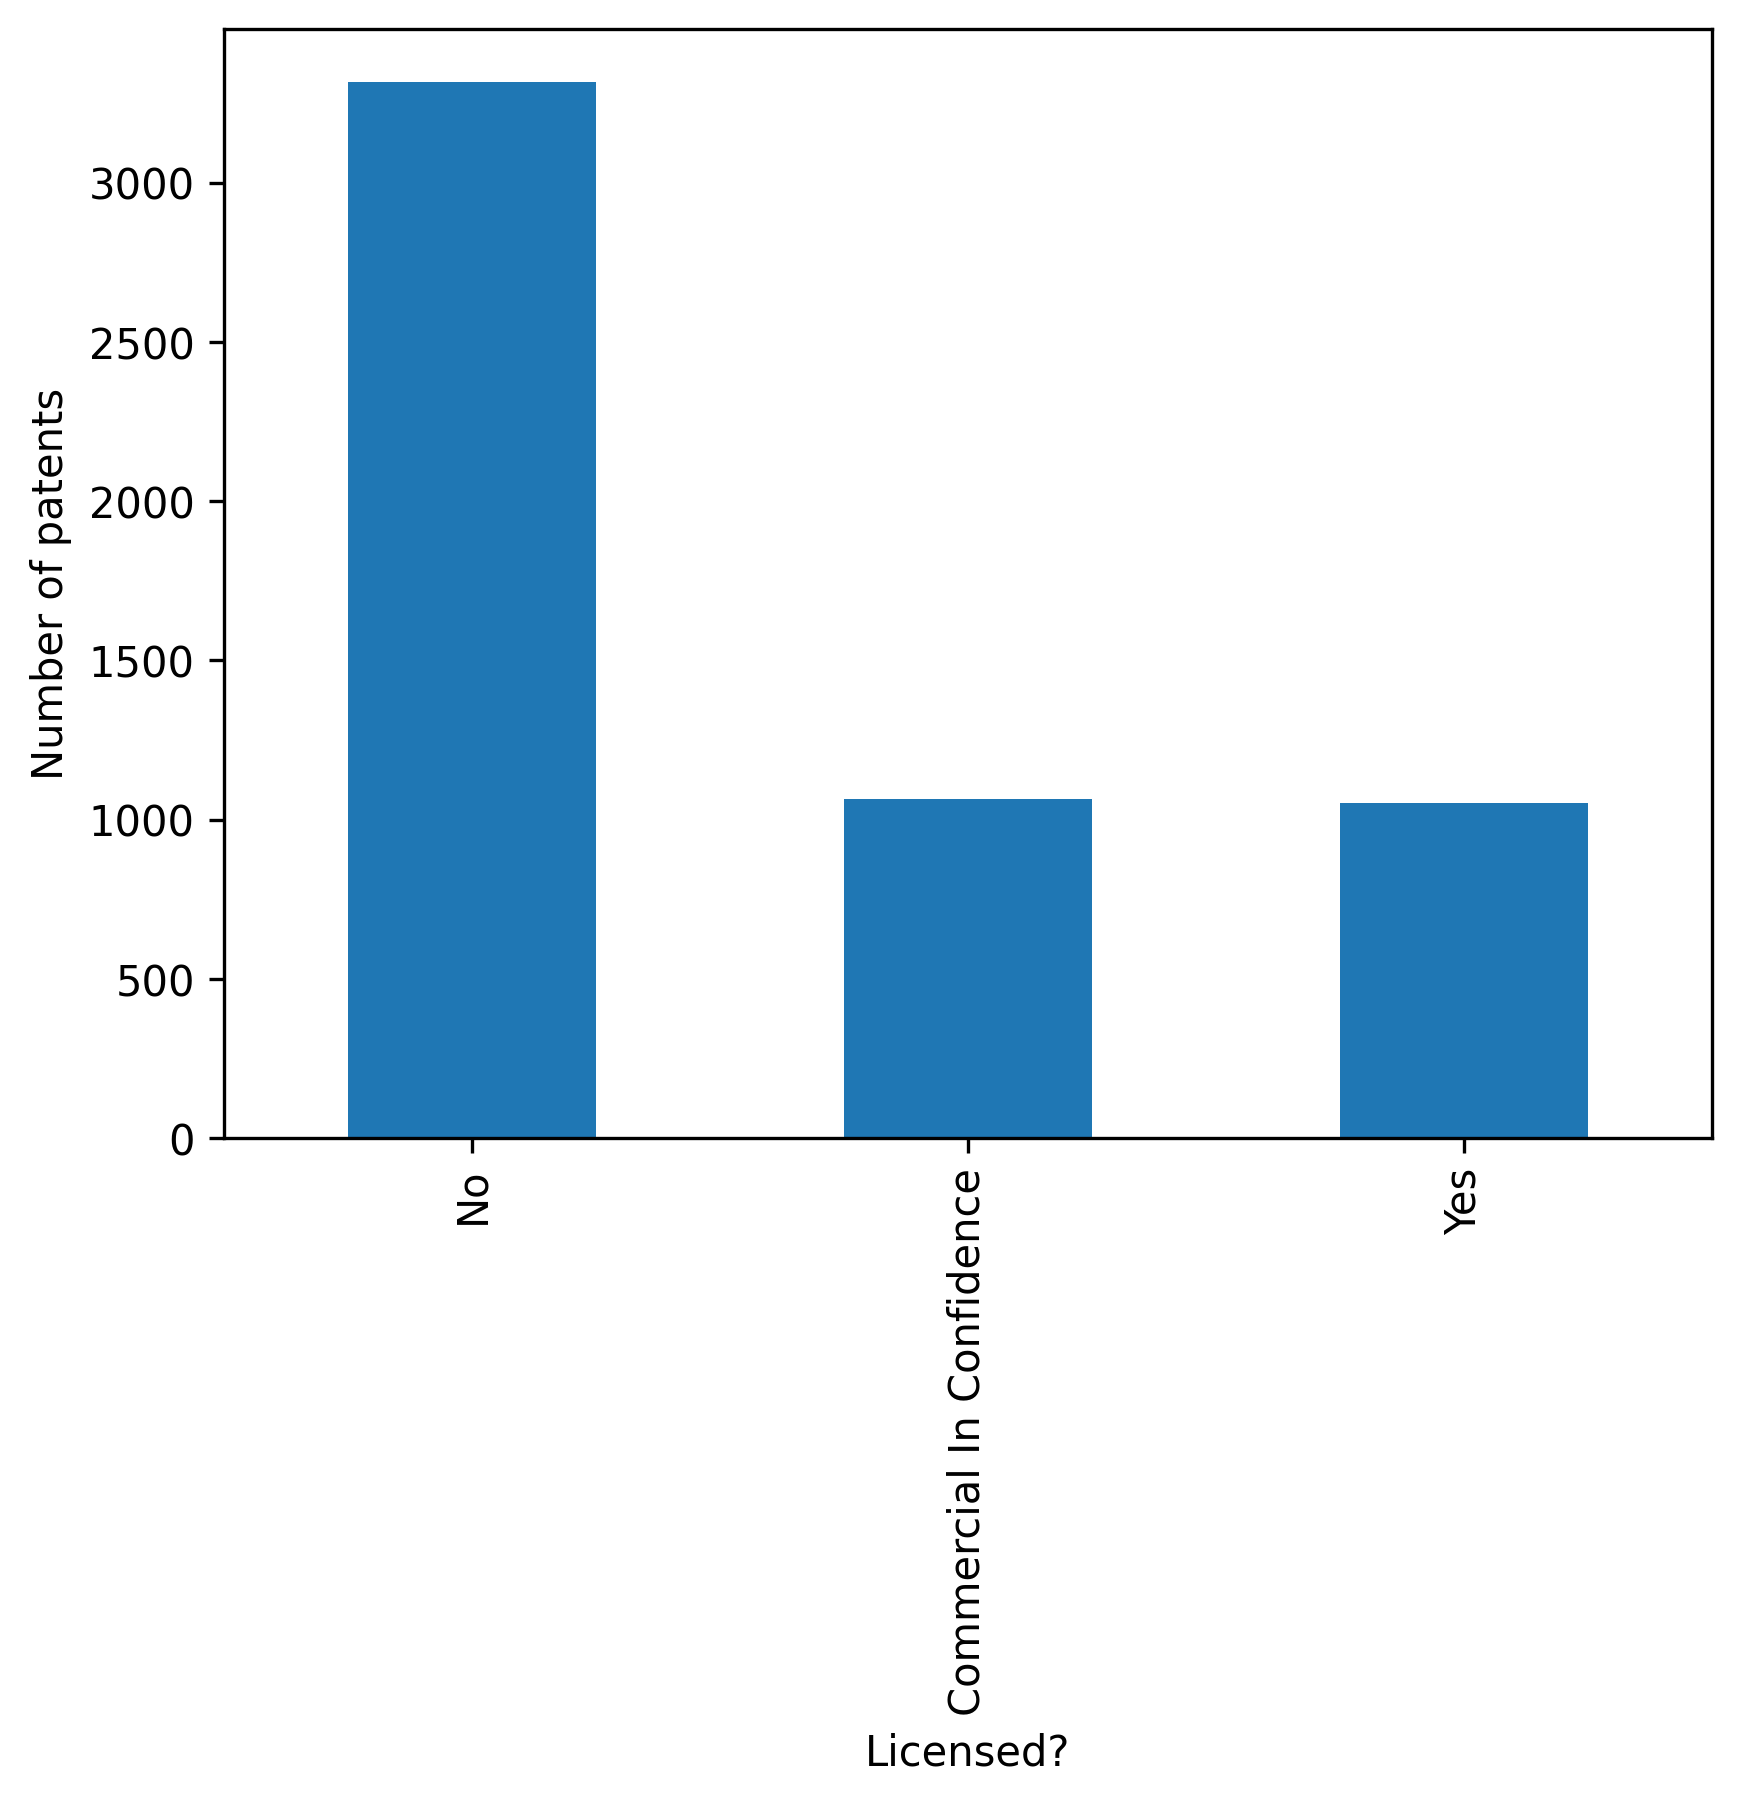

In [240]:
patent_values = ['Patent application published','Patent granted', 'Patent / Patent application']
df = df[df['Protection'].isin(patent_values)]

print(df['Licensed?'].value_counts())

df['Licensed?'].value_counts().plot(kind='bar')
plt.ylabel('Number of patents')
plt.show()

The 'Commercial In Confidence' value simply refers to the patent status not being stated. These can be dropped for the clustering analysis.

Next we can see how different funding organisations contribute to IP: 

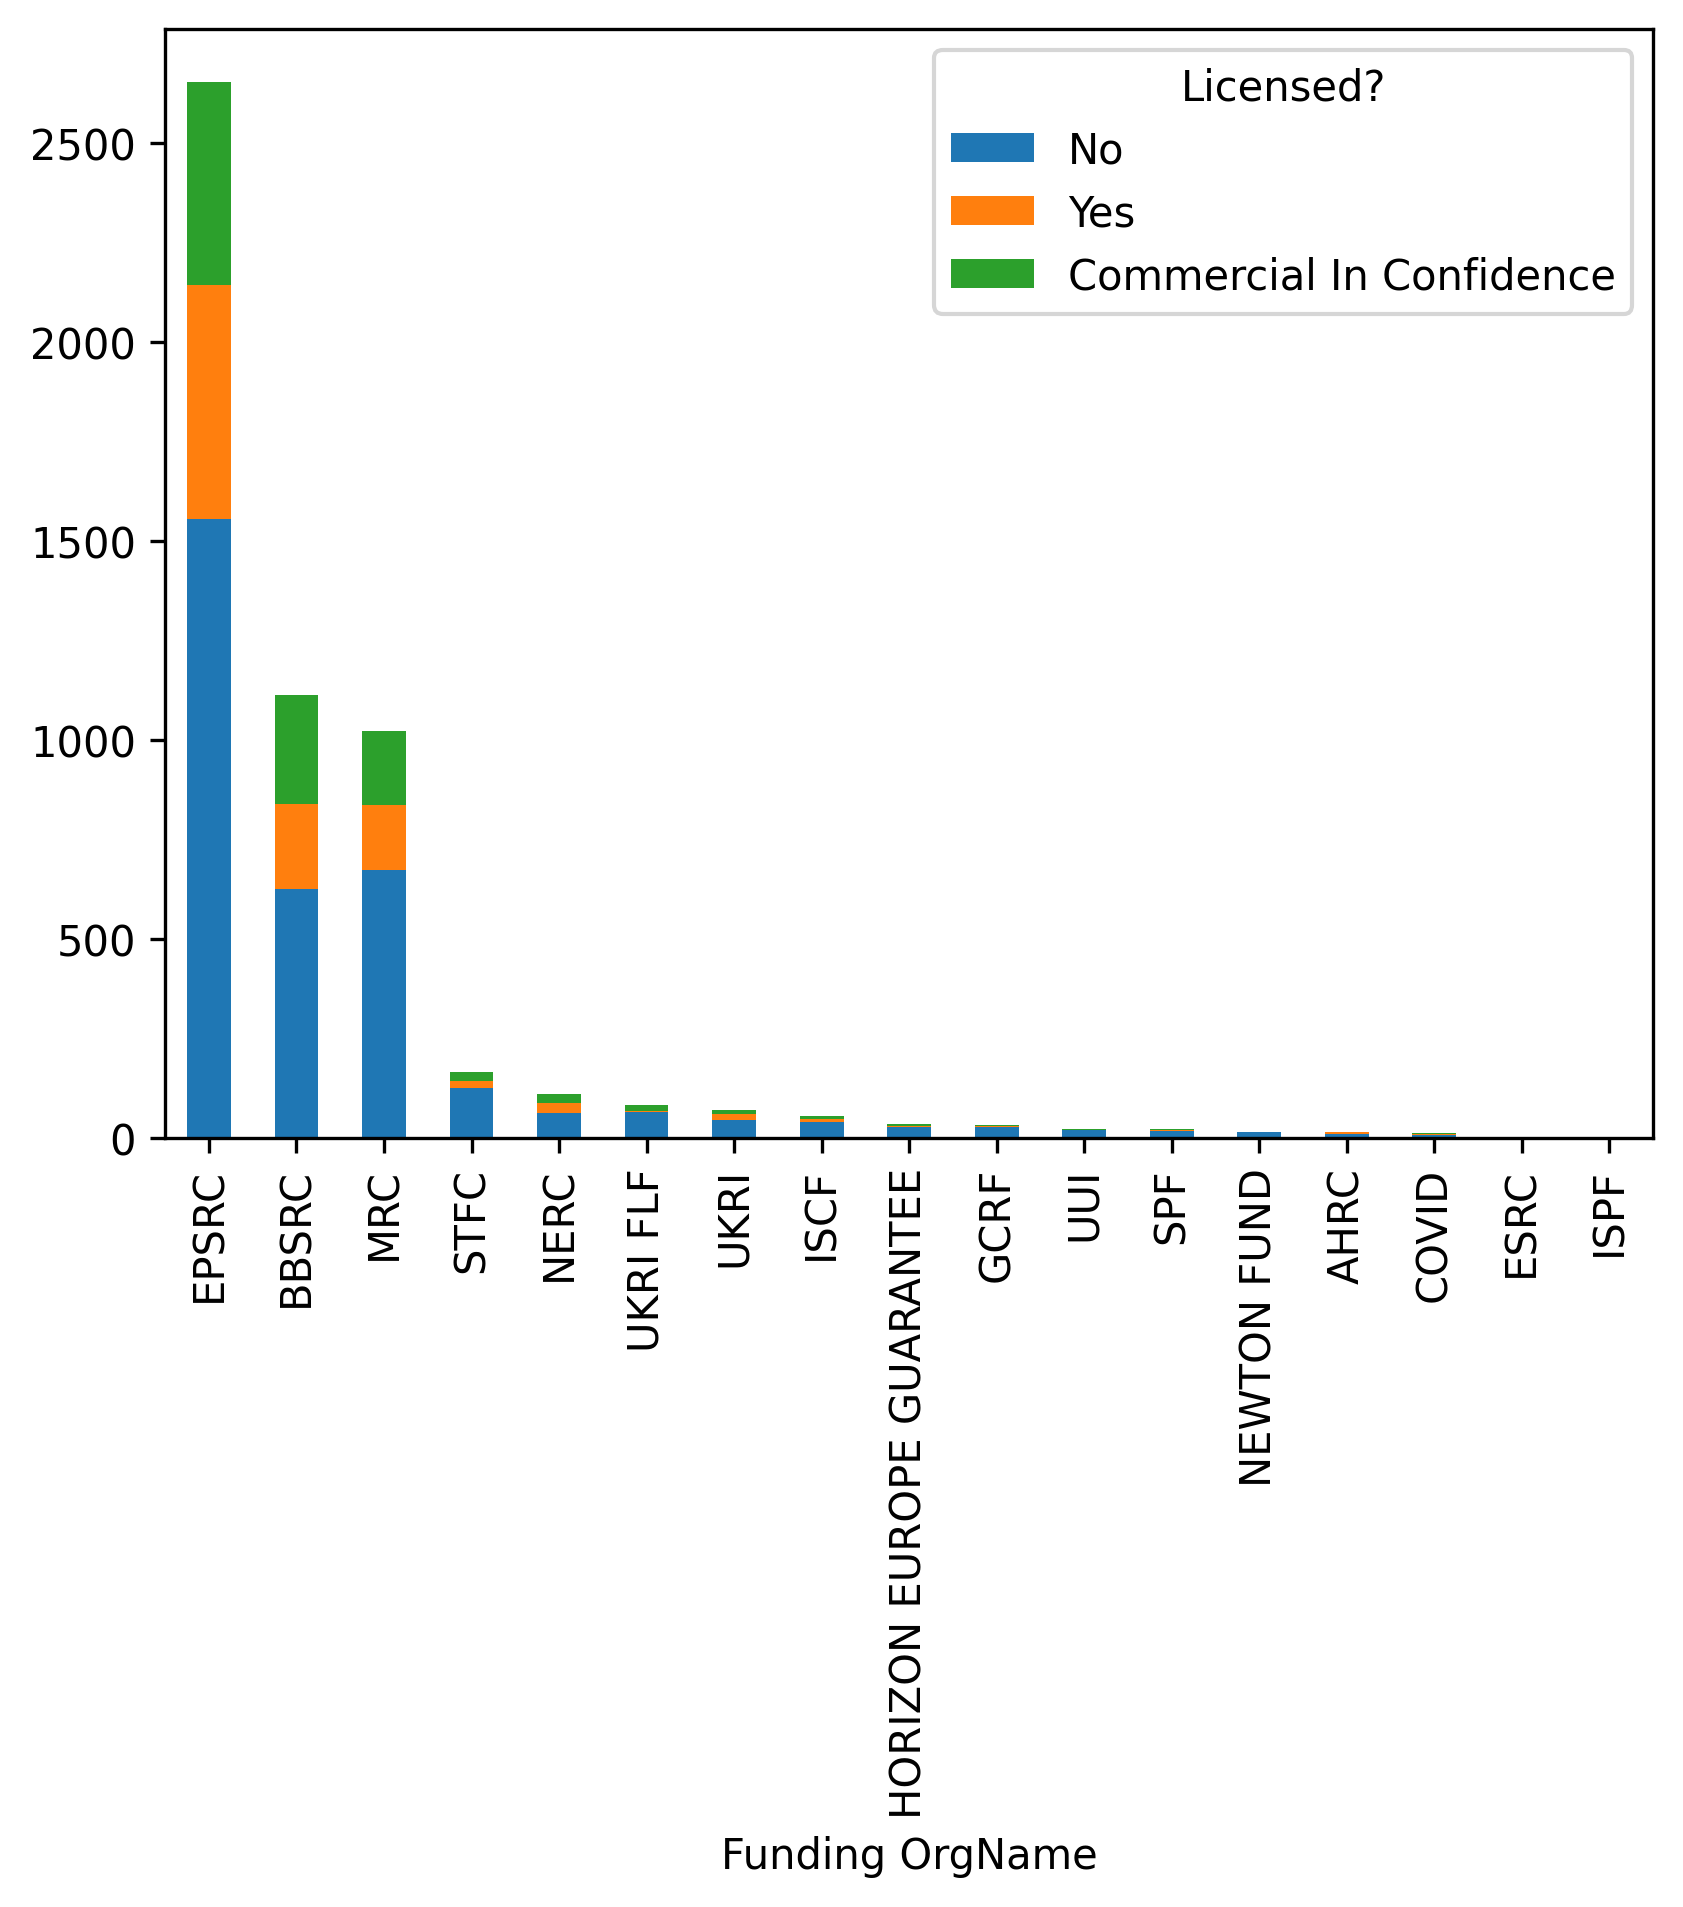

In [241]:
def get_unstacked(df,category):
    df = df.copy()
    unstacked_df = df.groupby(category)['Licensed?'].value_counts().unstack(fill_value=0)
    unstacked_df['Total'] = unstacked_df.sum(axis=1)
    sorted_df = unstacked_df.sort_values('Total',ascending=False)
    return sorted_df

funding_org_groups = get_unstacked(df,'Funding OrgName')
funding_org_groups[['No','Yes','Commercial In Confidence']].plot(kind='bar',stacked=True)
plt.show()

Now by PI:

In [242]:
df['PI Name'] = df['PI First Name'] + " " + df['PI Surname']
get_unstacked(df,'PI Name').head(10)

Licensed?,Commercial In Confidence,No,Yes,Total
PI Name,,,,
Andrea Ferrari,50,17,2,69
John Fisher,4,24,35,63
Lord Robert Mair,0,48,2,50
Harish Bhaskaran,0,42,0,42
Steven Rannard,3,22,15,40
Matt Mowlem,18,17,4,39
Anthony Kucernak,0,0,31,31
Stephen Ward,11,15,5,31
Matthew Wood,9,12,9,30


Next, department:

In [243]:
get_unstacked(df,'Department').head(10)

Licensed?,Commercial In Confidence,No,Yes,Total
Department,,,,
UNLISTED,225,512,112,849
Chemistry,62,213,146,421
Engineering,87,123,22,232
Materials,12,95,20,127
Electronic and Electrical Engineering,28,85,12,125
Physics,33,71,14,118
Mechanical Engineering,11,56,45,112
Sch of Engineering,7,78,15,100
Engineering Science,14,28,39,81


A lot of departments are 'UNLISTED'. Perhaps our clustering analysis can determine more information about these.

### 3. Text Preprocessing
The clustering analysis will utilise the title and description fields, which contain the most semantic information. To performs analysis, we will remove nulls and check the lengths of strings.

In [244]:
print(len(df))
print(df['Description'].isnull().sum())
print(df['Outcome Title'].isnull().sum())

5431
45
1


It is unfeasible to work with descriptions that are null so these can be dropped.

In [245]:
df = df.dropna(subset=['Description','Outcome Title'])
df['Title_Description'] = df['Outcome Title'] + ': ' + df['Description']
len(df)

5386

We should check for duplicates - multiple organisations may submit the same outcomes:

In [246]:
duplicates = df[df['Title_Description'].duplicated()]
duplicates['Title_Description'].value_counts()

Title_Description
PPR DIVA vaccine: We ahve developed two PPR live attenuated DIVA vaccines that can differentiate between vaccinated and infected animals.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [247]:
df = df.drop_duplicates(subset=['Title_Description'],keep='first')


Next, we can check the distribution of Title_Description lengths:

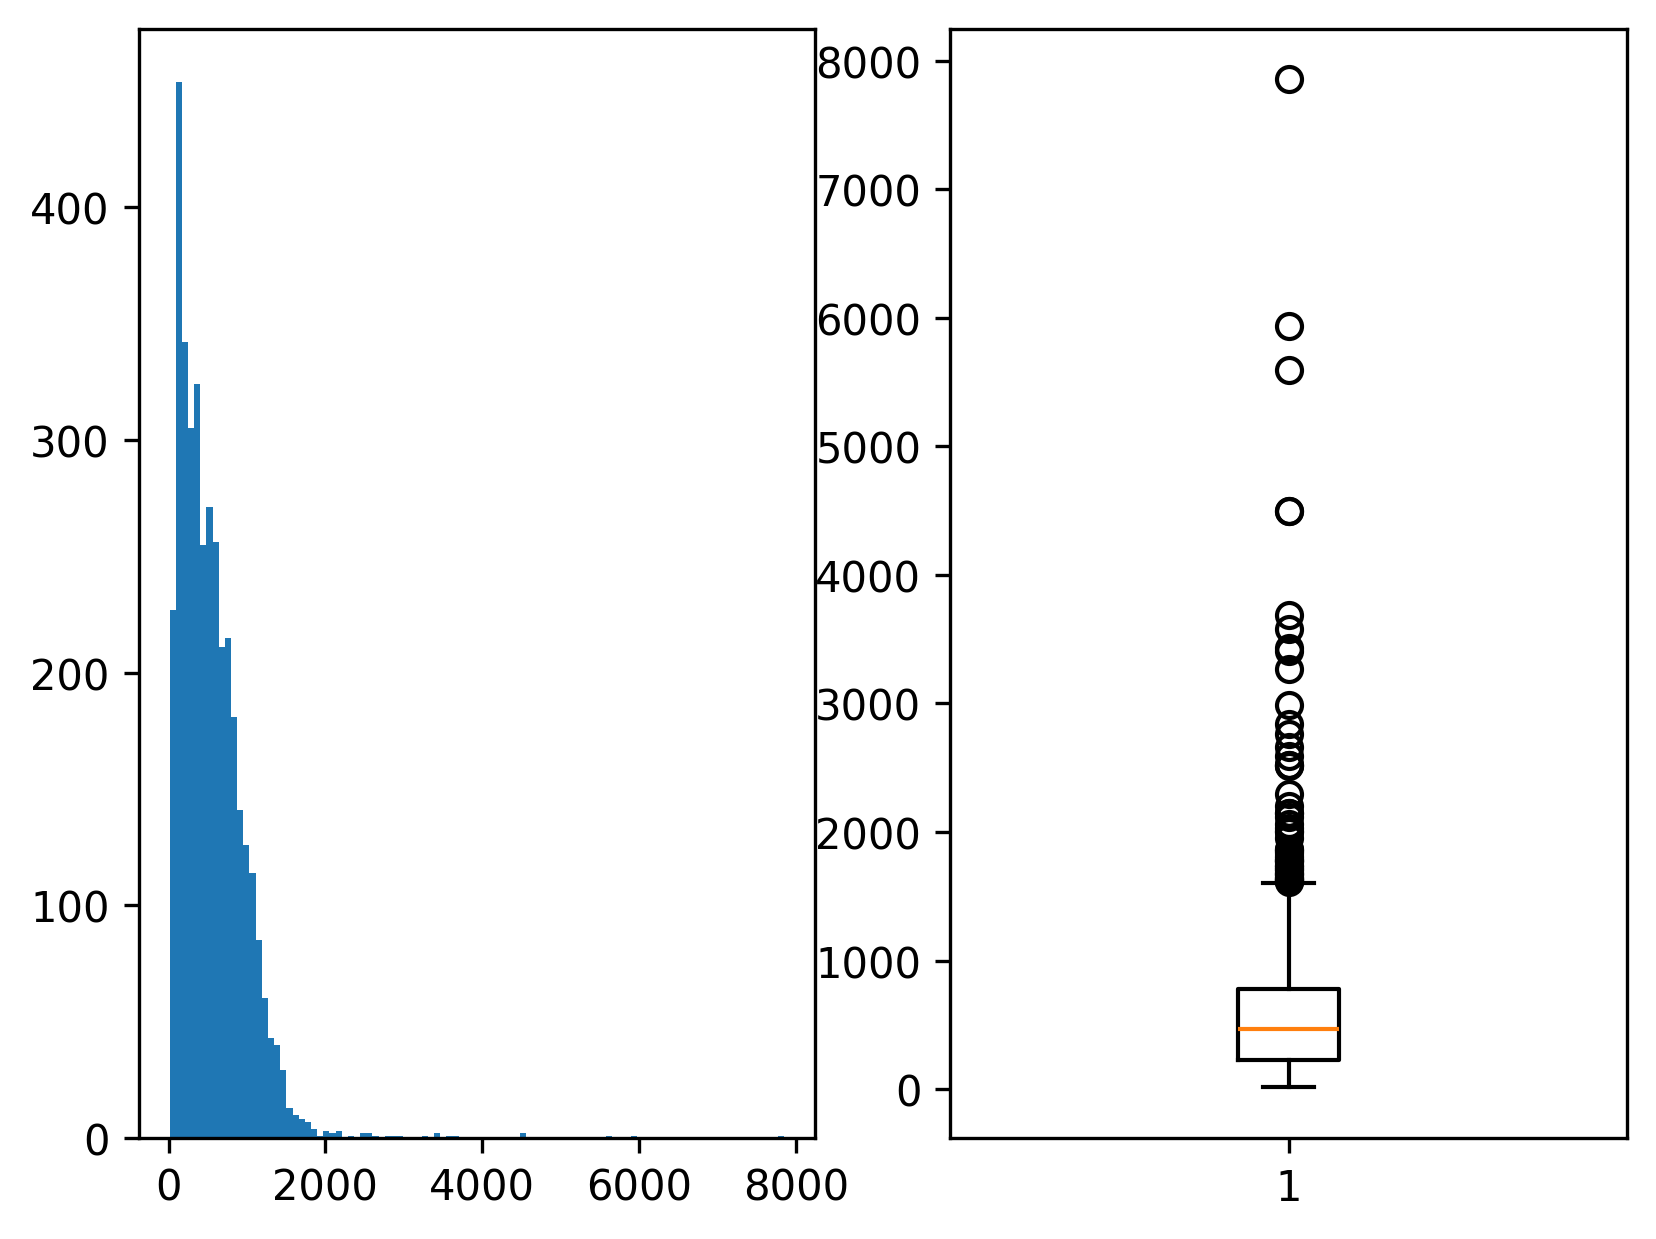

In [248]:
string_length = pd.DataFrame()
string_length['string'] = df['Title_Description']
string_length['length'] = string_length['string'].apply(lambda x: len(x))

fig, ax = plt.subplots(1,2)

ax[0].hist(x=string_length['length'],bins=100)
ax[1].boxplot(string_length['length'])
plt.show()

A lot of strings are uneccessarily long, which will slow down embedding without providing more information. There are also a lot of strings that are very short and won't provide enough information, these should be removed.

In [249]:
too_short = string_length['length'] < 80
print(string_length[too_short].sort_values('length',ascending=True)['string'].head(20))
print()
print(len(too_short))
print()
print(too_short.value_counts().head(10))

998                                        ?????SVG??: /
3706                                      Patent: Patent
3728                              Permipatch: Permipatch
422                           Confidential: Confidential
5124                    Optical Fibre Lasers: commercial
997                  ????????LCC-HVDC????????????????: /
5654               Resetting pluripotent stem cells: n.a
414           Process: New interative synthesis process.
2325          ECG EVALUATION: LifeMap Development - PERS
1960          MOT with hybrid coil: MOT with hybrid coil
2966          Pathfinder pill: Pathfinder Pill prototype
3184       ALLOY: 3D Printable Hard and Marageing Steels
962       Vacuum Viewport Member: Vacuum Viewport Member
2341     GRAVITY GRADIOMETER: Gravity gradiometer scheme
5195     Optimal T-cell killing cancer/virus patent: TBC
693     NMT inhibition new uses: NMT inhibition new uses
968     Ion Trap Assembly GB2313868.8: Ion Trap Assembly
613     DBR Enhanced micro-LEDs

In [250]:
string_length = string_length[string_length['length'] >= 80]

too_long = string_length['length'] > 3000
string_length[too_long]['length'].value_counts()

length
5935    1
3691    1
3583    1
4494    1
5596    1
4496    1
3428    1
7855    1
3408    1
3267    1
Name: count, dtype: int64

We can crop strings to a maximum of 3000 characters, to remove some of the lengthier strings.

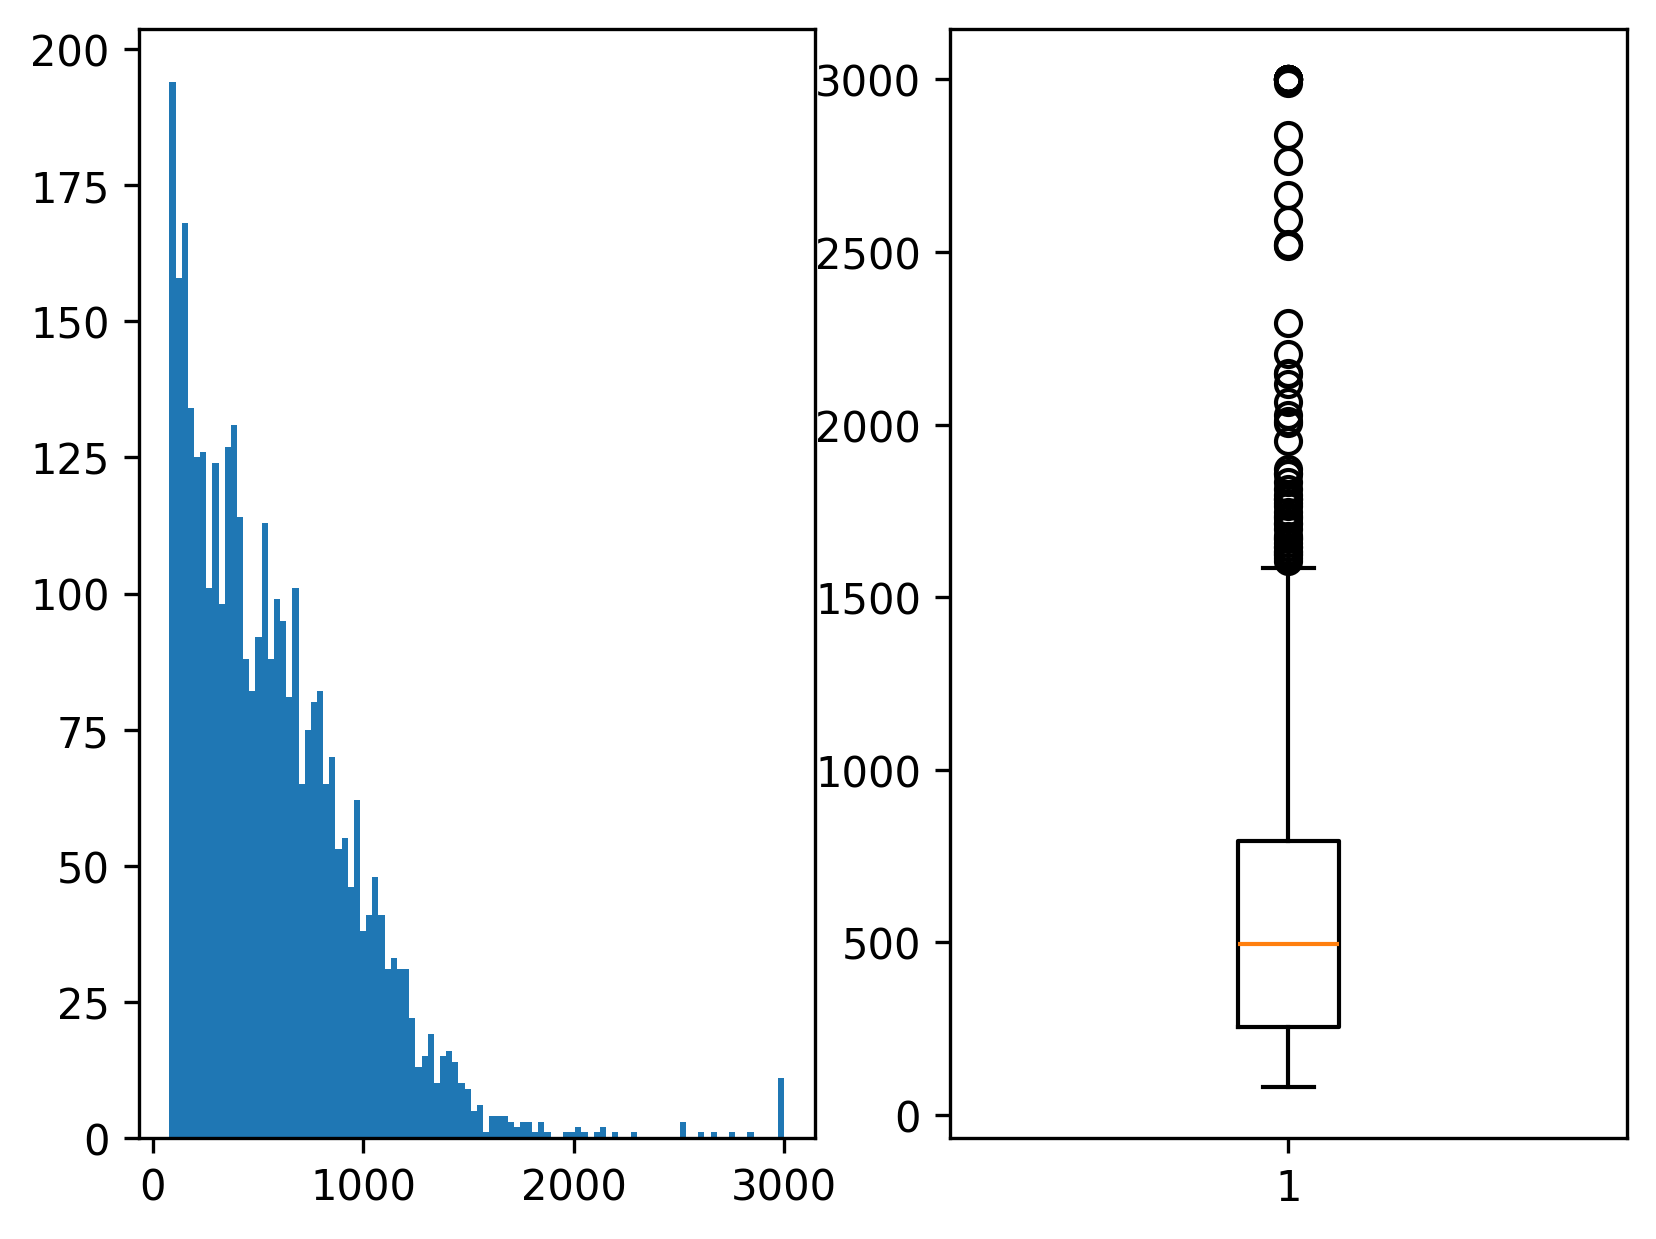

3597


In [251]:
string_length['string_cropped']  = string_length['string'].apply(lambda x: x[:3000])
string_length['length_cropped'] = string_length['string_cropped'].apply(lambda x: len(x))

fig, ax = plt.subplots(1,2)

ax[0].hist(x=string_length['length_cropped'],bins=100)
ax[1].boxplot(string_length['length_cropped'])
plt.show()
print(len(string_length))

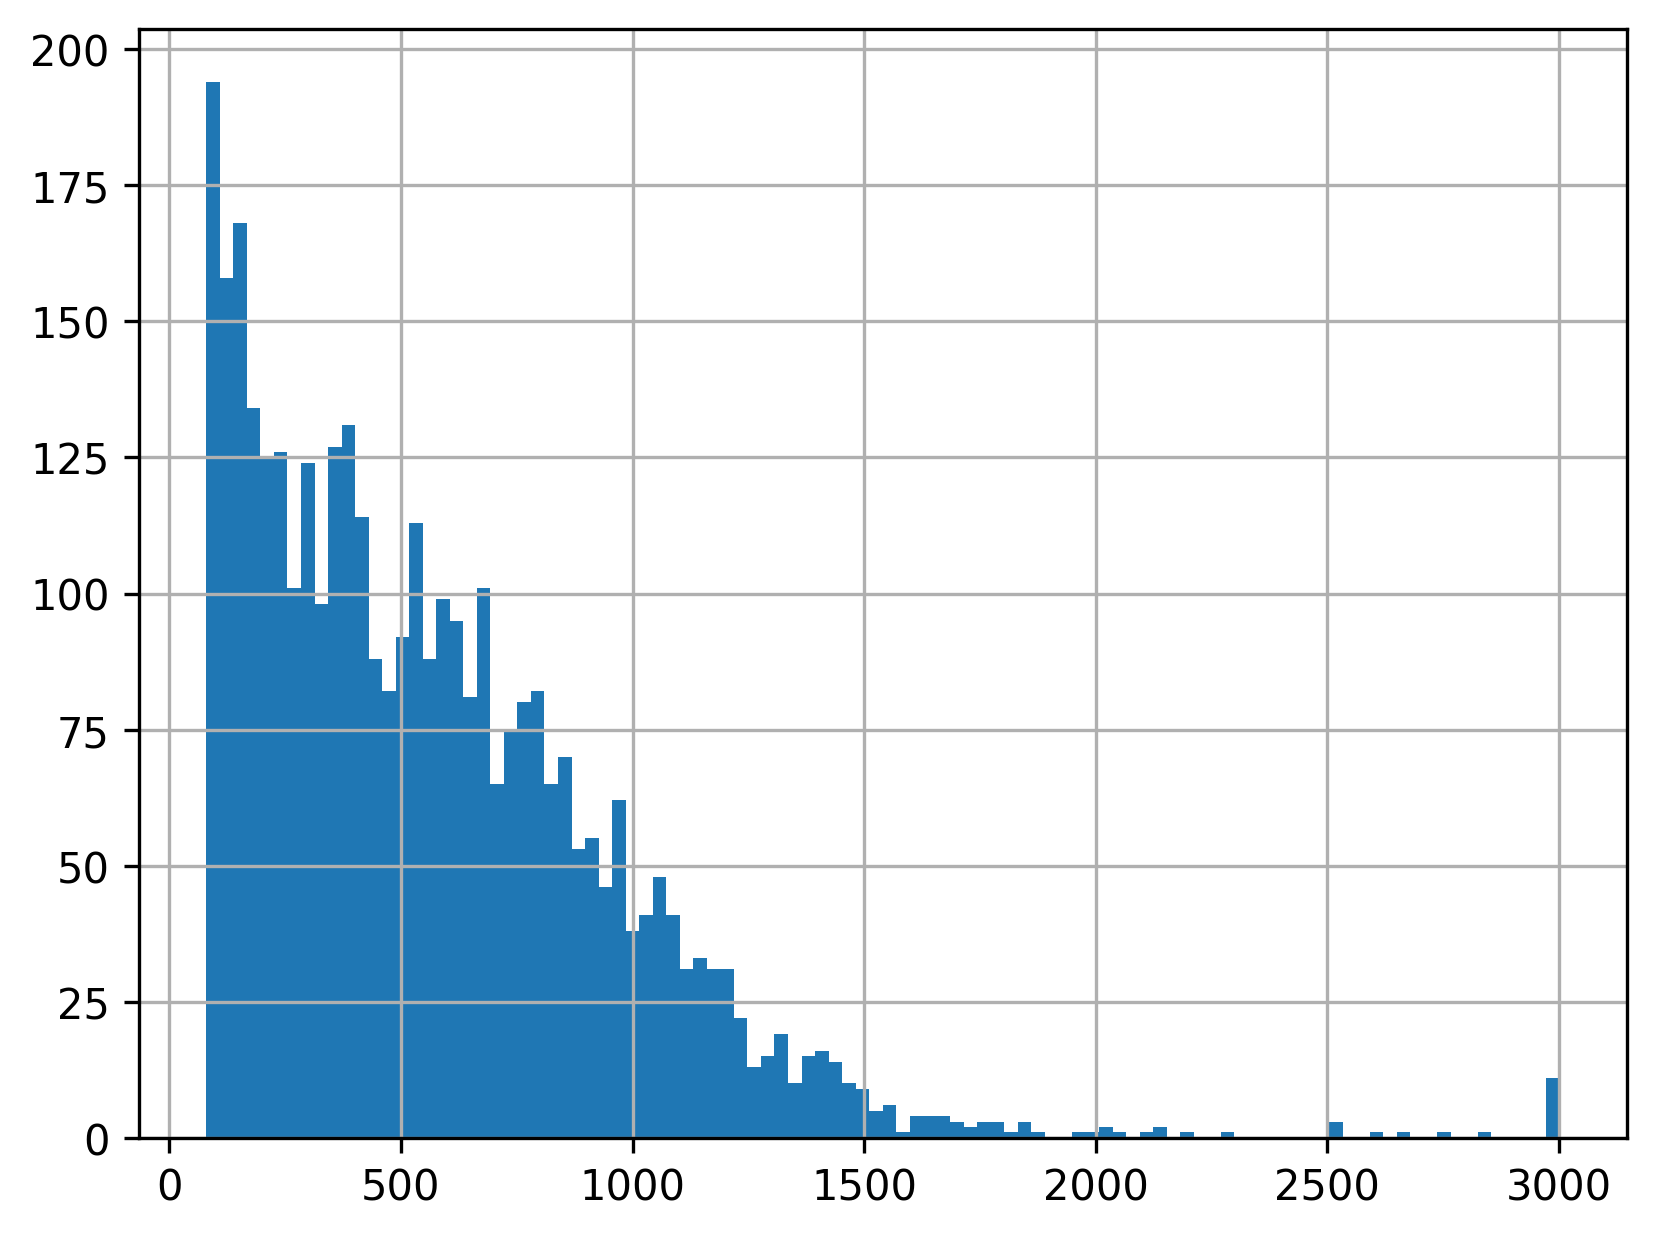

In [252]:
# Applying text preprocessing to actual data

df['title_desc_length'] = df['Title_Description'].apply(lambda x: len(x))
df = df[df['title_desc_length'] >= 80]
df['Title_Description'] = df['Title_Description'].apply(lambda x: x[:3000])
df['title_desc_length'] = df['Title_Description'].apply(lambda x: len(x))

df['title_desc_length'].hist(bins=100)
plt.show()

### 4. Text Embeddings

We use AllenAI/SPECTER, a model trained on scientific papers, which is well suited for research-related patent descriptions. Embeddings are cached to avoid expensive recomputation.

In [276]:
from sentence_transformers import SentenceTransformer
import json
import numpy as np
try:
    embeddings = np.load('embeddings.npy')
except:
    model = SentenceTransformer('sentence-transformers/allenai-specter')
    embeddings = model.encode(df['Title_Description'].to_list(), show_progress_bar=True)
    np.save('embeddings.npy',embeddings)


In [254]:
embeddings.shape

(3597, 768)

The model provides 768 dimensions, which will be prone to the 'curse of dimensionality'. For this reason, we should apply a dimensionality reduction.

### 5. Dimensionality Reduction and Clustering

Three approaches are compared: 

- **PCA** - fast and preserves global structure, more suited to linear data
- **t-SNE** - slower, good for local structure, non linear. More suited to visualisation
- **UMAP** - balanced, maintains more local and gloval structure, good for clustering

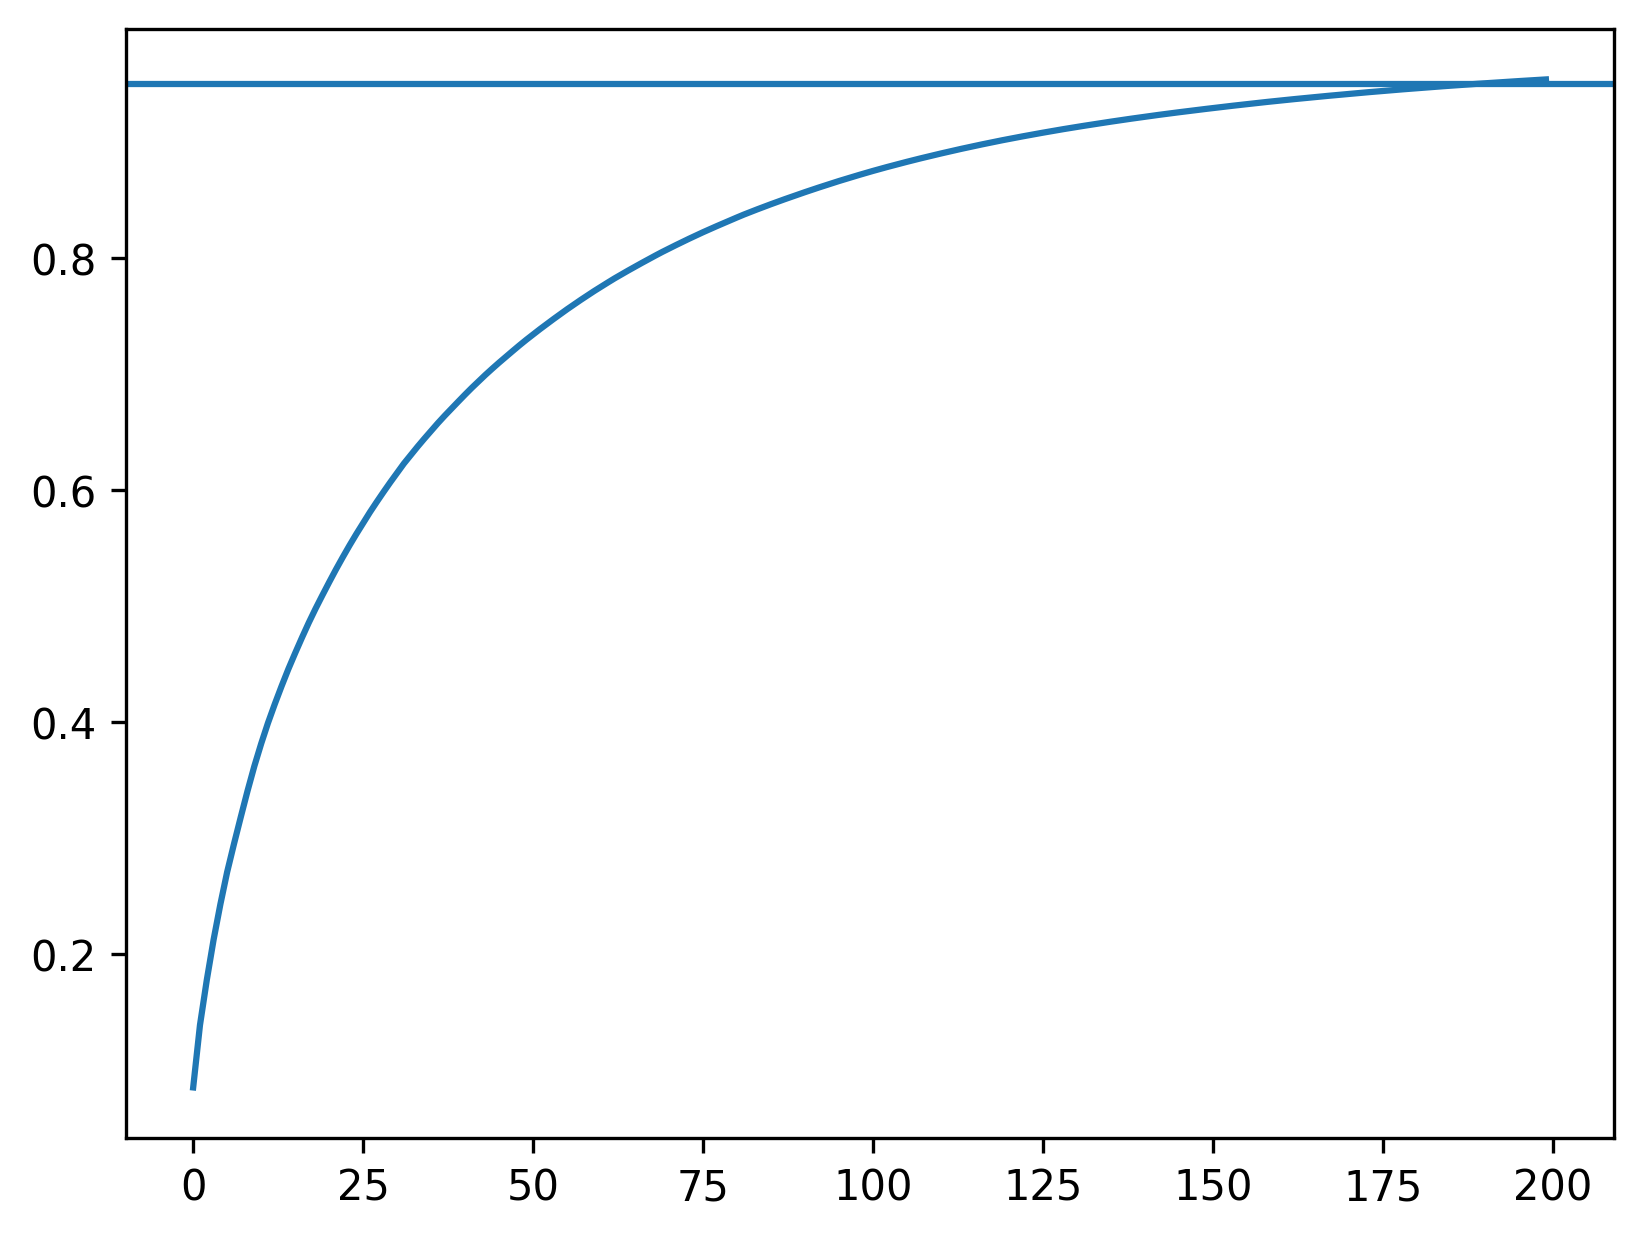

In [255]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=200)
reduced = pca.fit_transform(embeddings)
plt.plot(pca.explained_variance_ratio_.cumsum()) # Check how many dimensions are needed to maintain variance
plt.axhline(0.95) # Rough cut off point
plt.show()

We can check the mean and minimum standard deviations to ensure that each and every dimension is sufficiently useful:

In [256]:
print(f'Mean variance: {np.std(reduced, axis=0).mean():.2f}') 
print(f'Minimum variance: {np.std(reduced, axis=0).min():.2f}')  

Mean variance: 0.78
Minimum variance: 0.26


Now we can use k-means clustering with the PCA-reduced embeddings. Other clustering methods were attempted, such as DBSCAN and HDBSCAN, but the size of the dataset and these methods' rapidly scaling memory requirements led to the environment crashing

In [257]:
import plotly.express as px
from sklearn.cluster import MiniBatchKMeans

pca_visual = PCA(n_components=3)
reduced_pca2 = pca_visual.fit_transform(embeddings)

kmeans = MiniBatchKMeans(n_clusters=16, random_state=1, batch_size=256)
clusters = kmeans.fit_predict(reduced)

print(pd.Series(clusters).value_counts())
fig = px.scatter(x=reduced_pca2[:,0],y=reduced_pca2[:,1],color=clusters)
fig.show(config=config)

1     479
0     370
13    331
6     318
3     315
7     284
2     263
11    249
5     208
8     175
14    141
15    132
4     123
10    118
9      89
12      2
Name: count, dtype: int64


This shows that the k-means clustering algorithm has a generally good split between clusters. The visualisation shows some sense of clustering but it's difficult to see. We can plot these same clusters on a t-SNE visualisation to see it more clearly.

In [258]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
reduced_tsne = tsne.fit_transform(embeddings)

# Using t-SNE-reduced data is generally not recommended for clustering

kmeans_tsne = MiniBatchKMeans(n_clusters=16, random_state=1, batch_size=256) 
clusters_tsne = kmeans_tsne.fit_predict(reduced_tsne)


Now we can plot the clustering results from the PCA method on the t-SNE dimensions:

In [259]:
fig = px.scatter(x=reduced_tsne[:,0],y=reduced_tsne[:,1],color=clusters)
fig.show(config=config)

For reference, this is how t-SNE clusters the data:

In [260]:
fig = px.scatter(x=reduced_tsne[:,0],y=reduced_tsne[:,1],color=clusters_tsne)
fig.show(config=config)

Now we can try UMAP which is suitable for both visualisation and clustering:

In [261]:
import umap

reducer = umap.UMAP()

kmeans_umap = MiniBatchKMeans(n_clusters=16, random_state=1, batch_size=256)
reduced_umap = reducer.fit_transform(embeddings)

clusters_umap = kmeans_umap.fit_predict(reduced_umap)

fig = px.scatter(x=reduced_umap[:,0],y=reduced_umap[:,1],color=clusters_umap, title='UMAP cluster projection of UKRI-funded patent data ')
fig.show(config=config)

### 6. Silhouette Score

The Silhouette score is a useful metric for assessing the quality of clustering data. A higher score means better clustering.

In [262]:
from sklearn.metrics import silhouette_score

pca_score = silhouette_score(reduced,clusters)
umap_score = silhouette_score(reduced_umap,clusters_umap)
tsne_score = silhouette_score(reduced_tsne,clusters_tsne)
print(f'PCA: {pca_score:.2f}')
print(f'UMAP: {umap_score:.2f}')
print(f't-SNE: {tsne_score:.2f}')

PCA: 0.05
UMAP: 0.37
t-SNE: 0.34


UMAP achieved the highest silhouette score, indicating that points are most associated with their clusters. We should also test a range of k values to optimise for silhouette score, if possible.

In [277]:
import statistics

for k in range(15,25):
    kmeans_umap_ktest = MiniBatchKMeans(n_clusters=k, random_state=1, batch_size=256)
    silhouette_scores = []
    for i in range(3):
        reduced_umap_ktest = reducer.fit_transform(embeddings)
        clusters_umap_ktest = kmeans_umap_ktest.fit_predict(reduced_umap_ktest)
        silhouette_scores.append(silhouette_score(reduced_umap_ktest,clusters_umap_ktest))
    avg_score = statistics.mean(silhouette_scores)
    print(f'k: {k} - {avg_score:.2f}')

k: 15 - 0.37
k: 16 - 0.37
k: 17 - 0.37
k: 18 - 0.38
k: 19 - 0.39
k: 20 - 0.38
k: 21 - 0.39
k: 22 - 0.39
k: 23 - 0.40
k: 24 - 0.39


Varying the number of clusters does not have a significant effect on clustering quality. We can stick with 10 clusters as a compromise between breadth and specificity of the cluster.

In [264]:
# Free up memory by removing large embeddings array
try:
    del embeddings
    gc.collect()
except:
    pass

In [265]:
df['cluster'] = clusters_umap

### 7. Cluster Analysis

Now let's visualise the split between the clusters, in particular if the clusters show variation between accepted and rejected patents:

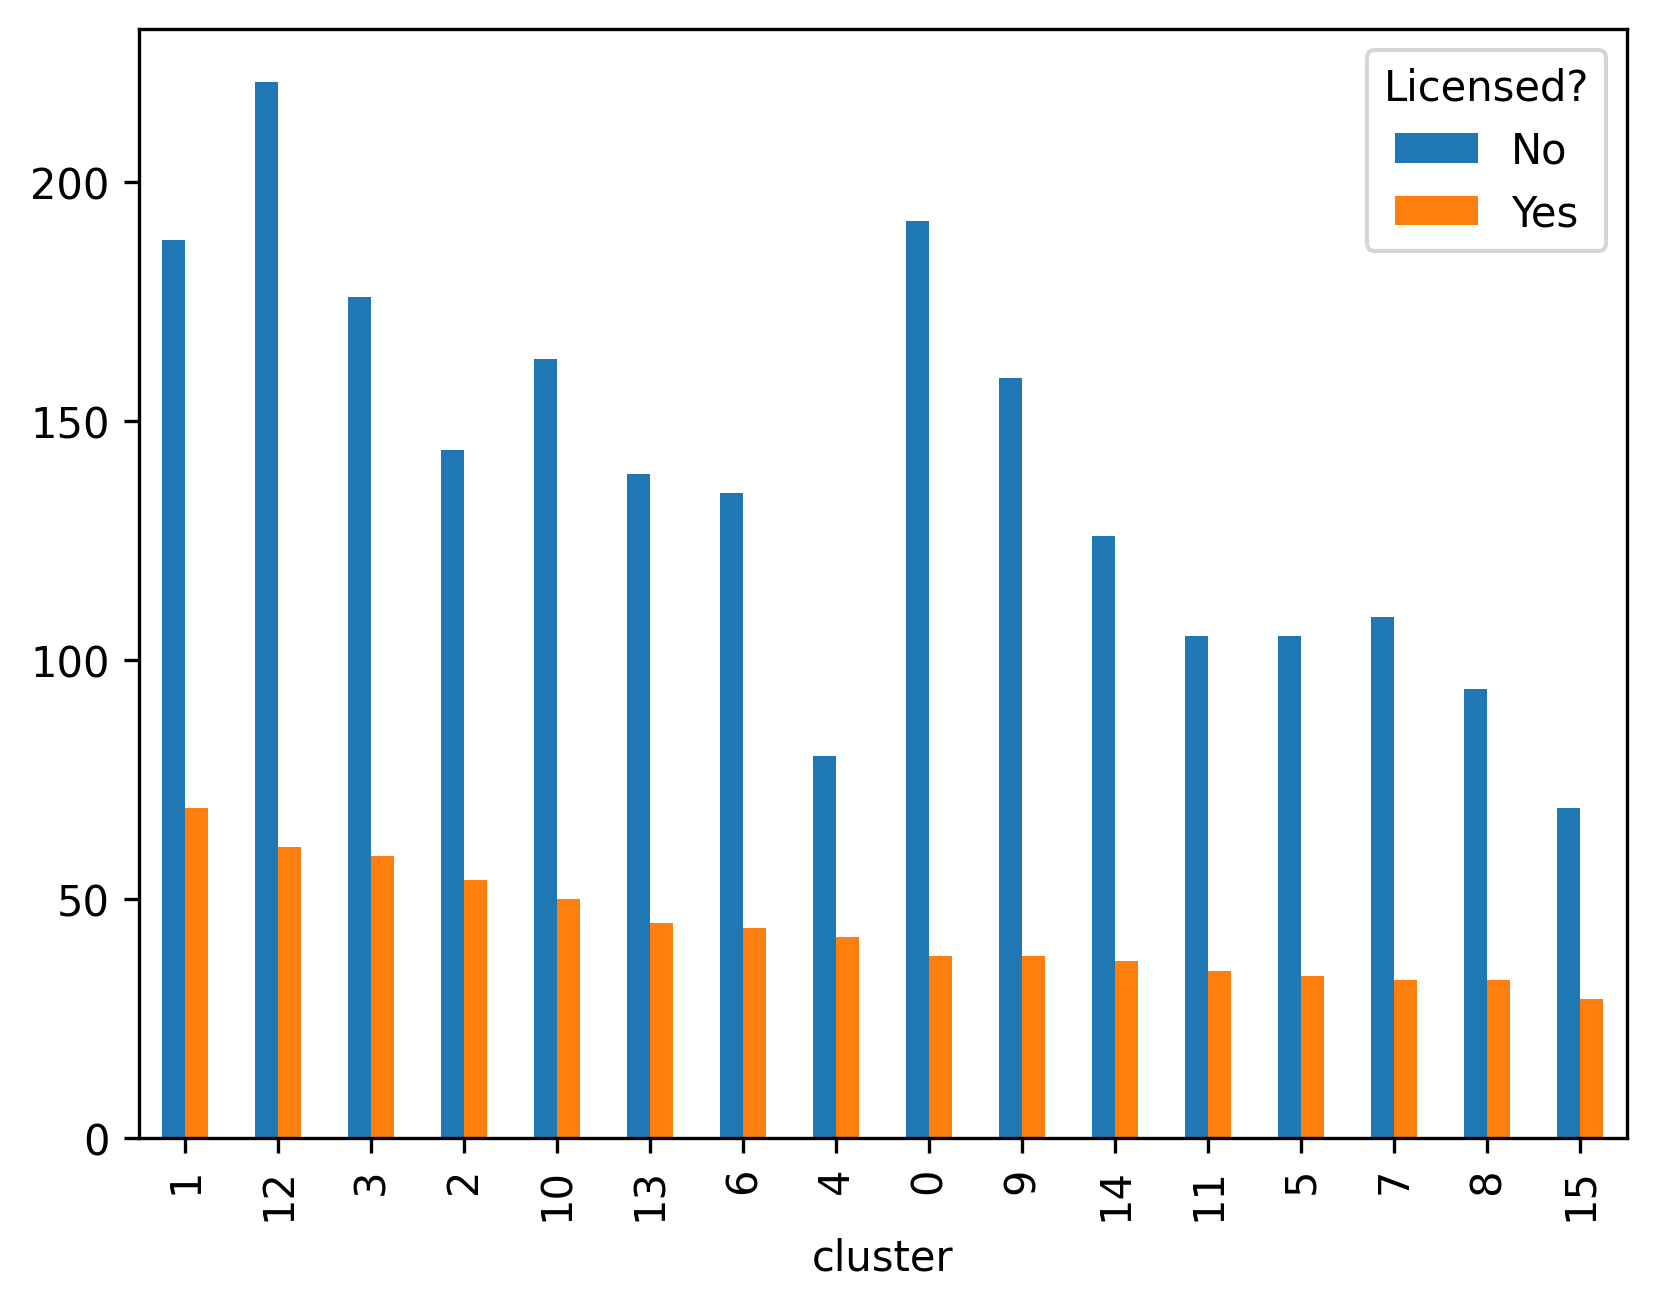

['PREDICTIVE USE OF CPG METHYLATION: RXRA for obesity or adiposity, body mass index and limb fat as an indicator of body fat distribution'
 'c-Jun????: A c-Jun antagonist is described. Also described are compositions comprising these c-Jun antagonists, as well as methods, methods of treatment comprising the c-Jun antagonists, and therapeutic uses.'
 'METHOD OF DIAGNOSIS OF ADRENAL INSUFFICIENCY: The disclosure relates to a composition comprising adrenocorticotropic hormone (ACTH) or a synthetic ACTH analogue for use in a diagnostic test for adrenal insufficiency. A method to conduct said diagnostic test; a combined diagnostic and method of treatment;and kits comprising the components for said test are also disclosed.'
 'GENE THERAPY FOR RETINAL DISEASE: The invention provides methods for treating, preventing or reversing retinal degeneration. The methods administering to the subject a vector that expresses a Cadherin-related family member 1 (CDHR1) polypeptide. The invention also provi

In [266]:
cluster_patents= df.groupby('cluster')['Licensed?'].value_counts().unstack()
cluster_patents['Total'] = cluster_patents.sum(axis=1)
cluster_patents_ordered = cluster_patents.sort_values('Yes',ascending=False)

cluster_patents_ordered[['No','Yes']].plot(kind='bar')
plt.show()
for i in range(0,5):
    print(df[df['cluster'] == cluster_patents_ordered.index[i]]['Title_Description'].sample(20).values)
    print()

The cursory glance at each cluster above shows some reasonable clustering of research fields. We can also check if a cluster contains patents from similar departments:

### 8. Automated Cluster Labelling

Now we can use an LLM (via the Hugging Face inference API) to generative descriptive labels for each cluster. a random sample (n=20) is taken from each cluster to generate a message to pass to an LLM.

In [274]:
def get_chat_message(cluster,df:pd.DataFrame):
    cluster_df = df[df['cluster'] == cluster]
    sample = cluster_df.sample(50,random_state=42,replace=False)
    desc_strings = sample['Title_Description'].values
    desc_string = '--- '

    for desc in desc_strings:
        desc_string = desc_string + desc + ' --- '
    chat_request = f'Here are 50 research-related patent descriptions from a single cluster, separated by ---. What specific patent field unifies the majority of them? Be specific — avoid broad terms like "engineering" or "biotechnology". Reply with 2-4 words only, capitalise the first letter of each word. {desc_string}'

    return chat_request


chat_messages = {}
clusters = len(df['cluster'].unique())
for i in range(0,clusters):
    cluster_message = get_chat_message(i,df)
    chat_messages[i] = cluster_message
print(chat_messages[0][:500])

Here are 50 research-related patent descriptions from a single cluster, separated by ---. What specific patent field unifies the majority of them? Be specific — avoid broad terms like "engineering" or "biotechnology". Reply with 2-4 words only, capitalise the first letter of each word. --- SILICON PASSIVATION WITH THIN FILM OXIDE: A thin film passivation method comprises obtaining silicon comprising a silicon surface with an oxide layer (3a, 3b) thereon; and wetting the silicon surface with the 


In [268]:
import time
from huggingface_hub import InferenceClient
import os
from dotenv import load_dotenv
load_dotenv()

# Check if .csv already exists to avoid redundant LLM requests
if os.path.exists('ukri.csv'): 
    df = pd.read_csv('ukri.csv')
    print(df['cluster_category'].value_counts())
else:
    #Initiate HF client
    client = InferenceClient(token=os.environ.get('HF_TOKEN'))

    # Send chat responses to LLM
    chat_responses = {}
    for cluster, chat_message in chat_messages.items():
        response = client.chat_completion(
        model='openai/gpt-oss-120b',
        messages=[
            {'role':'user','content':chat_message}
        ]
        )
        chat_responses[cluster] = response.choices[0].message.content
        time.sleep(0.2)
    
    df['cluster_category'] = df['cluster'].map(chat_responses)
    df.to_csv('ukri.csv')



cluster_category
Photonic Devices              338
Advanced Materials            328
Optoelectronic Devices        287
Viral Vector Gene Therapy     286
Fluid Flow Instrumentation    264
Computational Imaging         251
Antimicrobial Therapeutics    230
Sensing And Measurement       224
Implantable Neural Devices    219
Nanostructured Materials      213
Cancer Immunotherapy          205
Tissue Engineering            174
Plant Genetic Engineering     158
Polymeric Drug Delivery       156
Biosensor Technology          150
Vaccine Development           114
Name: count, dtype: int64


In [269]:
df['cluster_category'].value_counts()

cluster_category
Photonic Devices              338
Advanced Materials            328
Optoelectronic Devices        287
Viral Vector Gene Therapy     286
Fluid Flow Instrumentation    264
Computational Imaging         251
Antimicrobial Therapeutics    230
Sensing And Measurement       224
Implantable Neural Devices    219
Nanostructured Materials      213
Cancer Immunotherapy          205
Tissue Engineering            174
Plant Genetic Engineering     158
Polymeric Drug Delivery       156
Biosensor Technology          150
Vaccine Development           114
Name: count, dtype: int64

In [270]:
df[df['cluster_category'] == 'Viral Vector Gene Therapy']['Title_Description'].values

array(['DNA DAMAGE TESTING: The invention relates to a method of for detecting DNA damage in a tissue sample. The method includes the steps of exposing sample DNA to a tagged DNA-damage binding factor and then shearing the DNA to produce fragments. After separating damaged from undamaged DNA, the two are amplified and differentially labeled. The labeled fragments can be immobilised on a microarray allowing the location and extent of any DNA damage to be determined.',
       'c-Jun????: A c-Jun antagonist is described. Also described are compositions comprising these c-Jun antagonists, as well as methods, methods of treatment comprising the c-Jun antagonists, and therapeutic uses.',
       'PREDICTIVE USE OF CPG METHYLATION: RXRA for obesity or adiposity, body mass index and limb fat as an indicator of body fat distribution',
       'PHENOTYPE PREDICTION BY DETERMINING THE METHYLATION STATUS OF GENES: Phenotypic characteristics selected from obesity and/or adiposity, bone health, and ca

### 9. Results: Patents by Research Domain

<Axes: ylabel='cluster_category'>

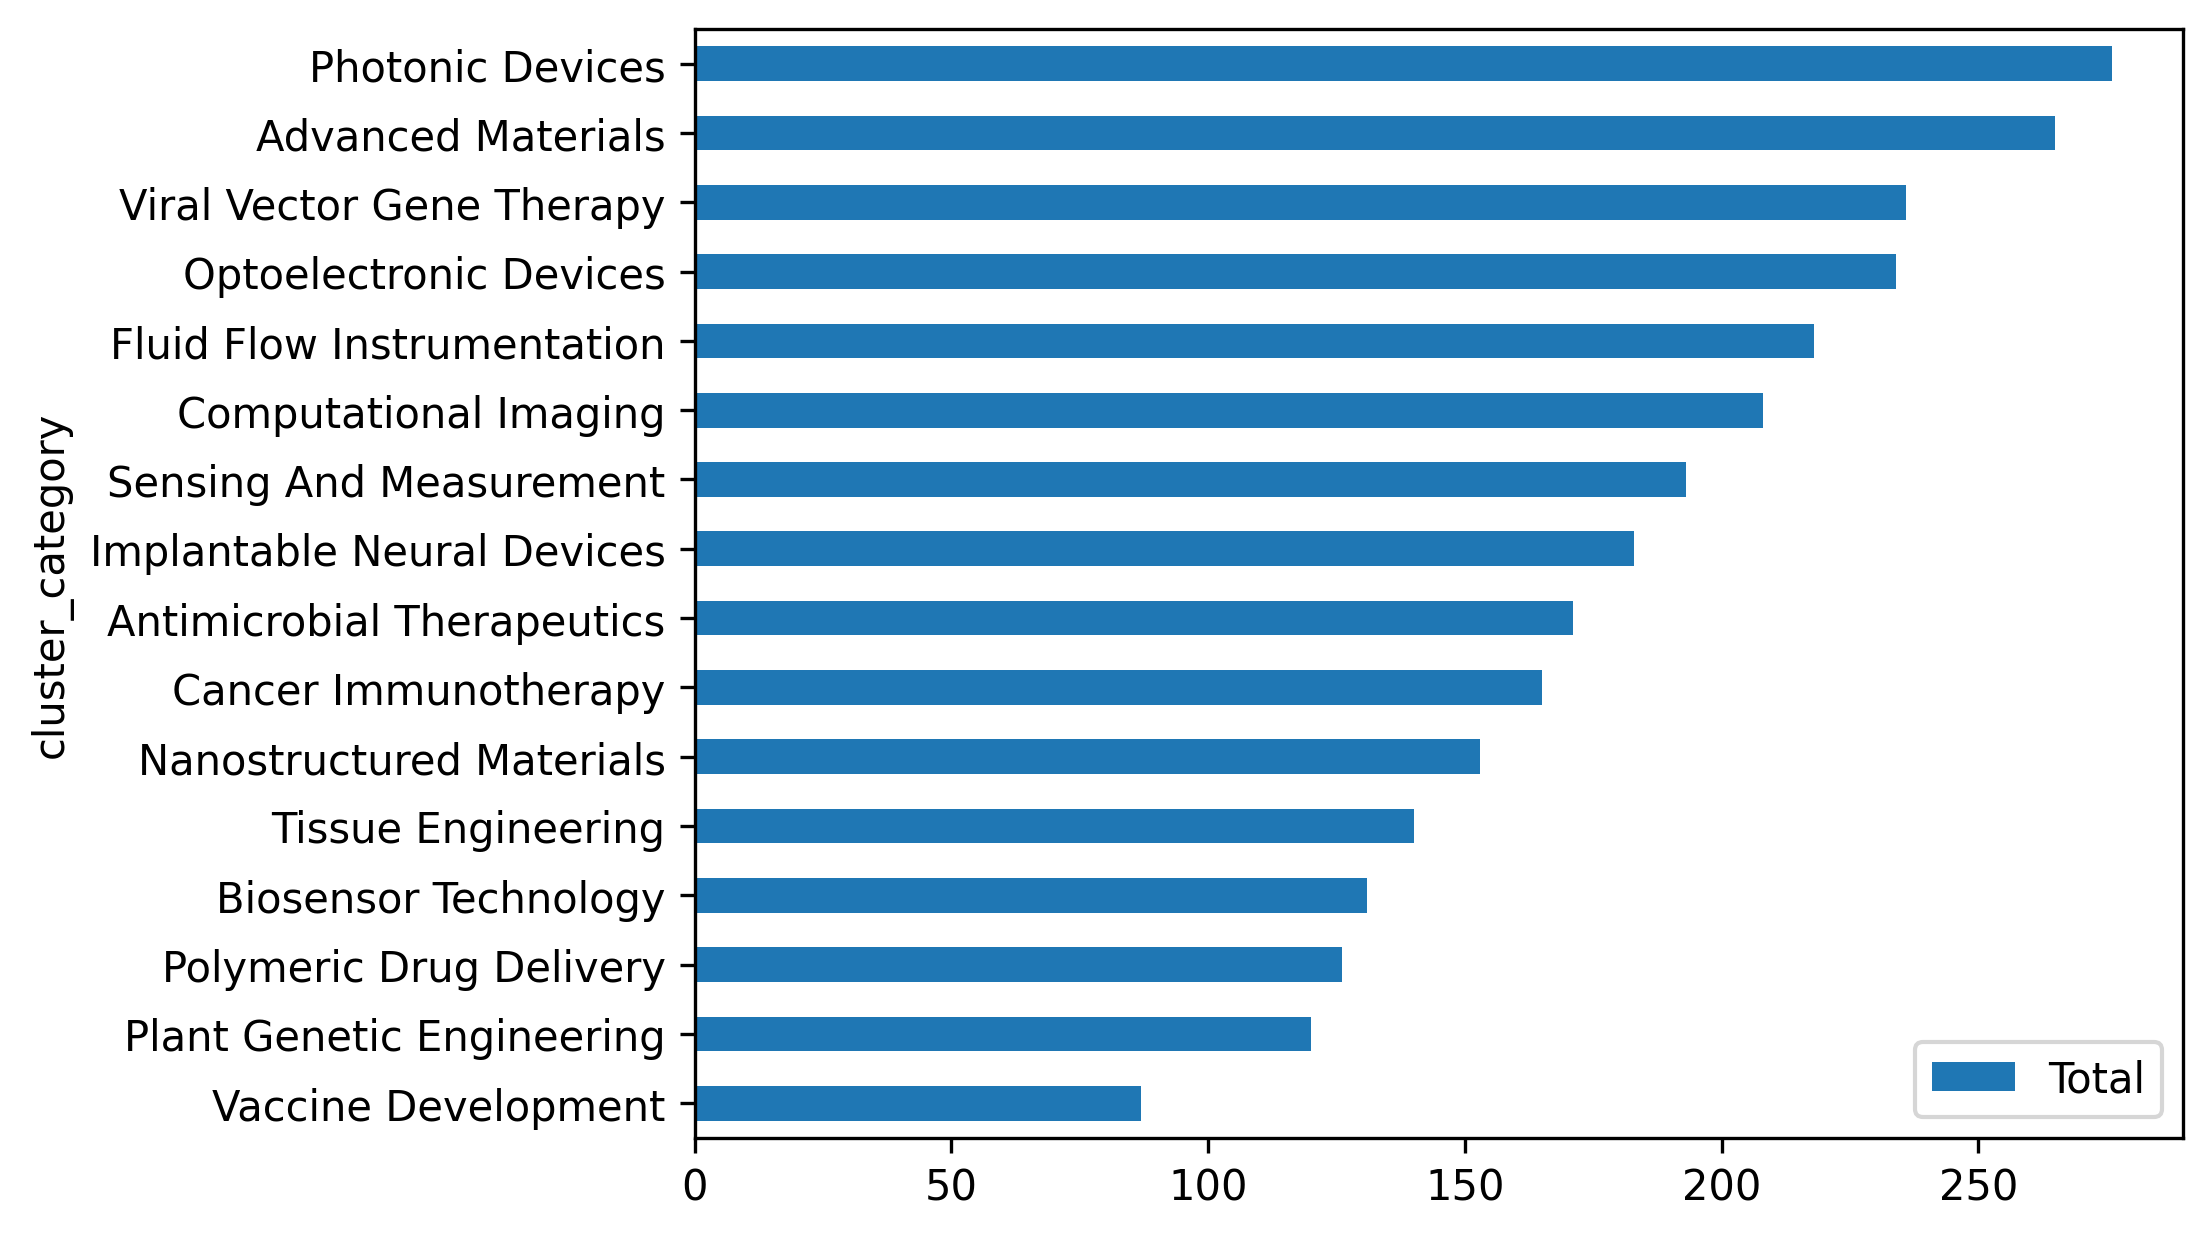

In [271]:
cluster_groups = df.groupby('cluster_category')['Licensed?'].value_counts().unstack()
cluster_groups = cluster_groups.fillna(0).sort_values('Yes').drop('Commercial In Confidence',axis=1)
cluster_groups['Total'] = cluster_groups['Yes'] + cluster_groups['No']
cluster_groups.sort_values('Total').plot(y='Total',kind=('barh'))

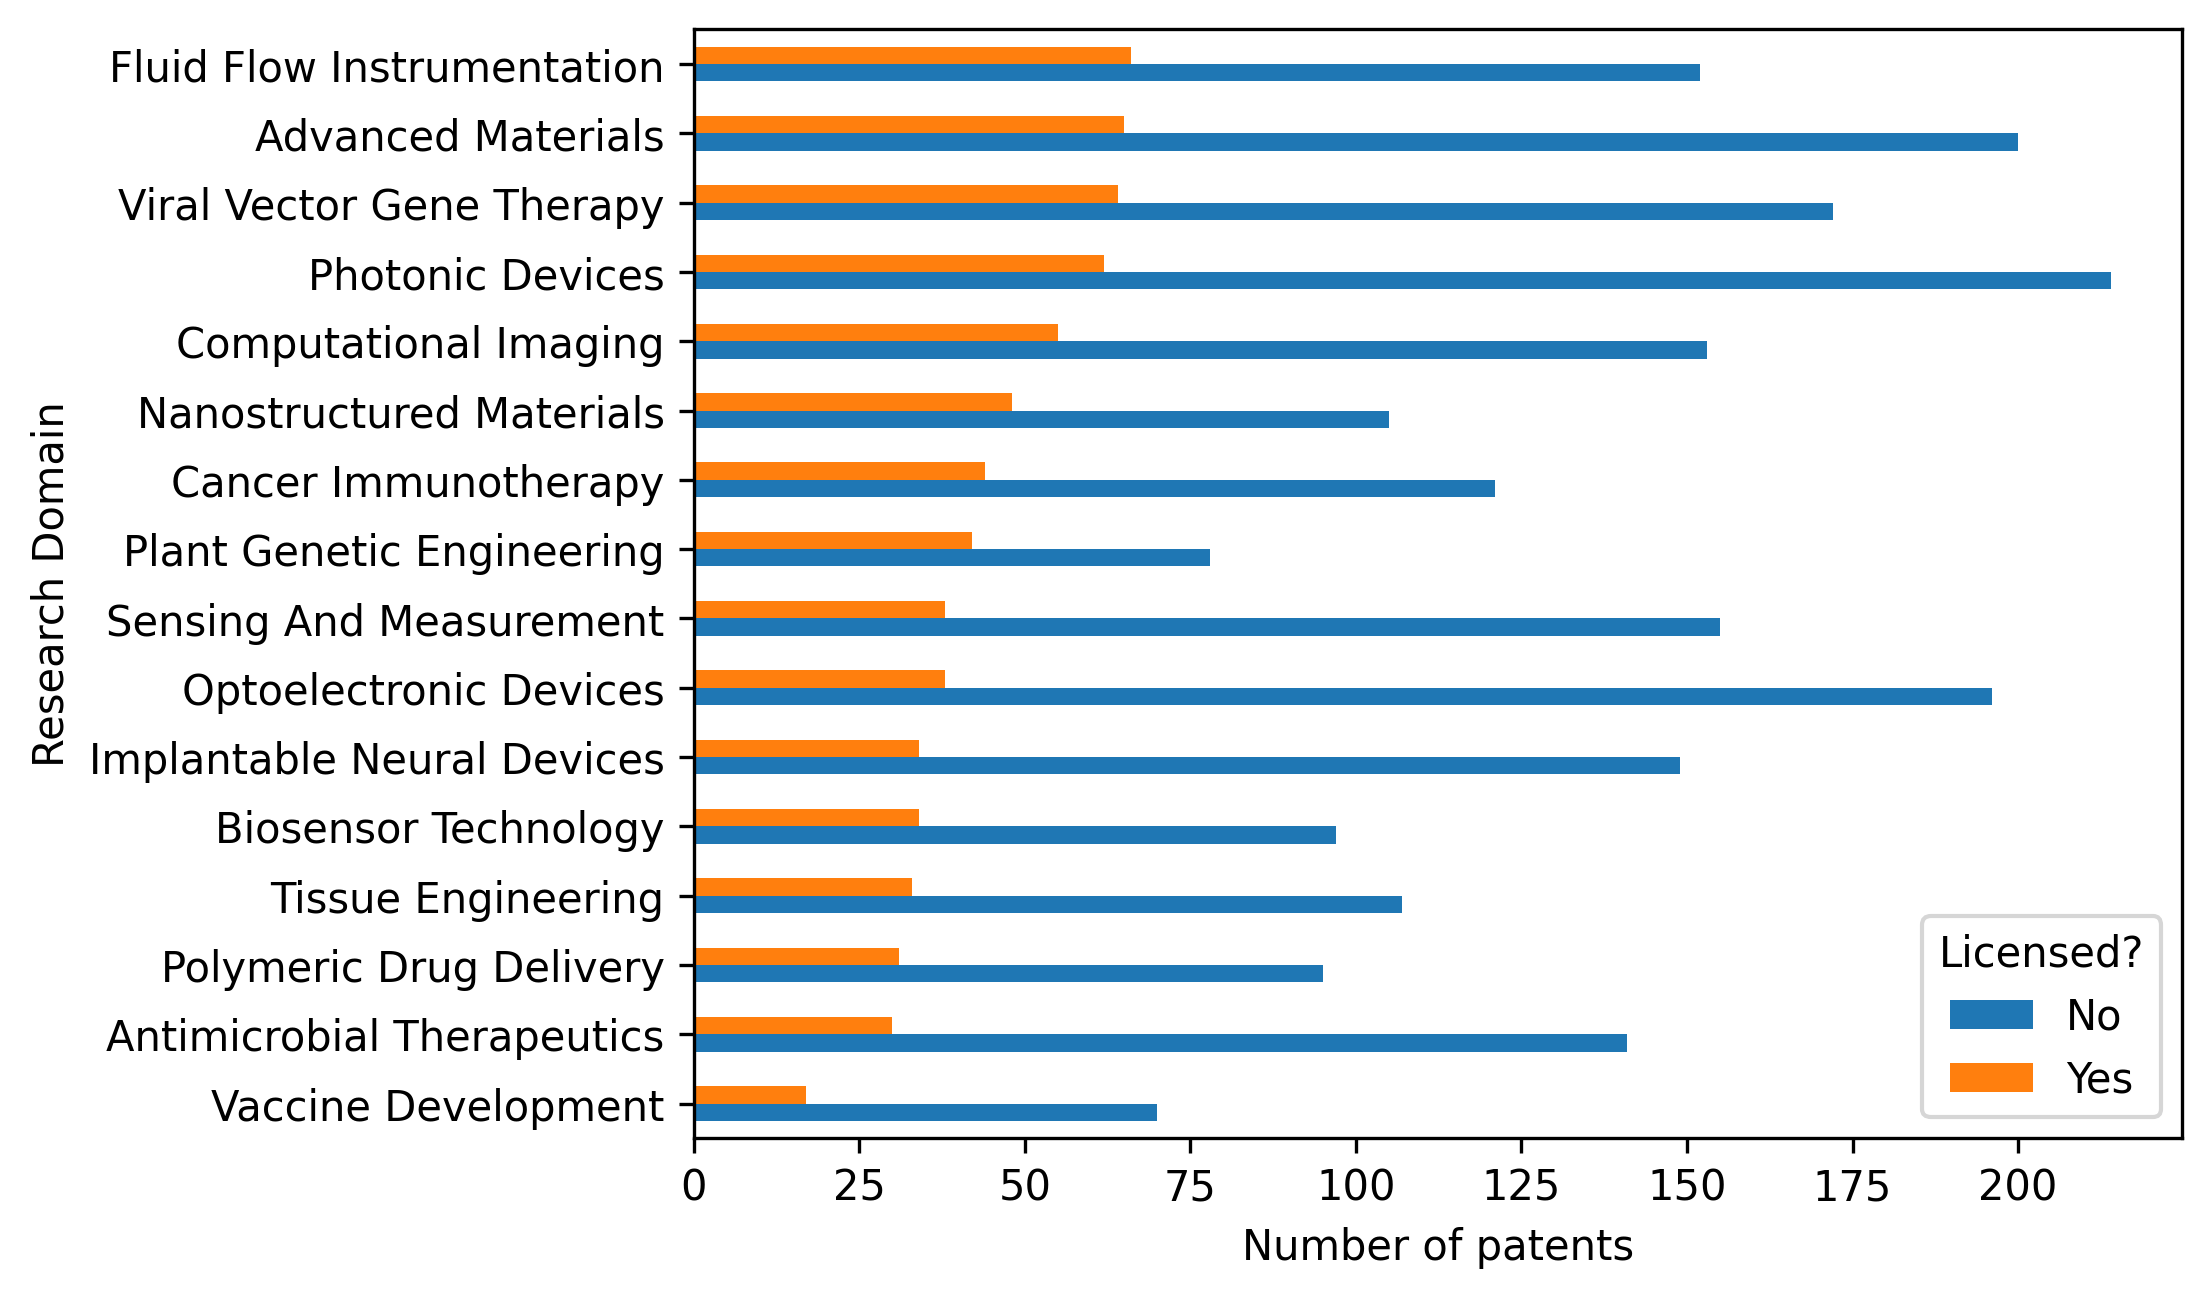

In [272]:
cluster_groups = df.groupby('cluster_category')['Licensed?'].value_counts().unstack()
cluster_groups = cluster_groups.fillna(0).sort_values('Yes').drop('Commercial In Confidence',axis=1)
cluster_groups.plot(kind='barh')
plt.xlabel('Number of patents')
plt.ylabel('Research Domain')
plt.show()

Licensed?                    No  Yes  Total  Yes_percent  No_percent
cluster_category                                                    
Photonic Devices            214   62    276     0.224638    0.775362
Advanced Materials          200   65    265     0.245283    0.754717
Viral Vector Gene Therapy   172   64    236     0.271186    0.728814
Optoelectronic Devices      196   38    234     0.162393    0.837607
Fluid Flow Instrumentation  152   66    218     0.302752    0.697248
Computational Imaging       153   55    208     0.264423    0.735577
Sensing And Measurement     155   38    193     0.196891    0.803109
Implantable Neural Devices  149   34    183     0.185792    0.814208
Antimicrobial Therapeutics  141   30    171     0.175439    0.824561
Cancer Immunotherapy        121   44    165     0.266667    0.733333
Nanostructured Materials    105   48    153     0.313725    0.686275
Tissue Engineering          107   33    140     0.235714    0.764286
Biosensor Technology         97   

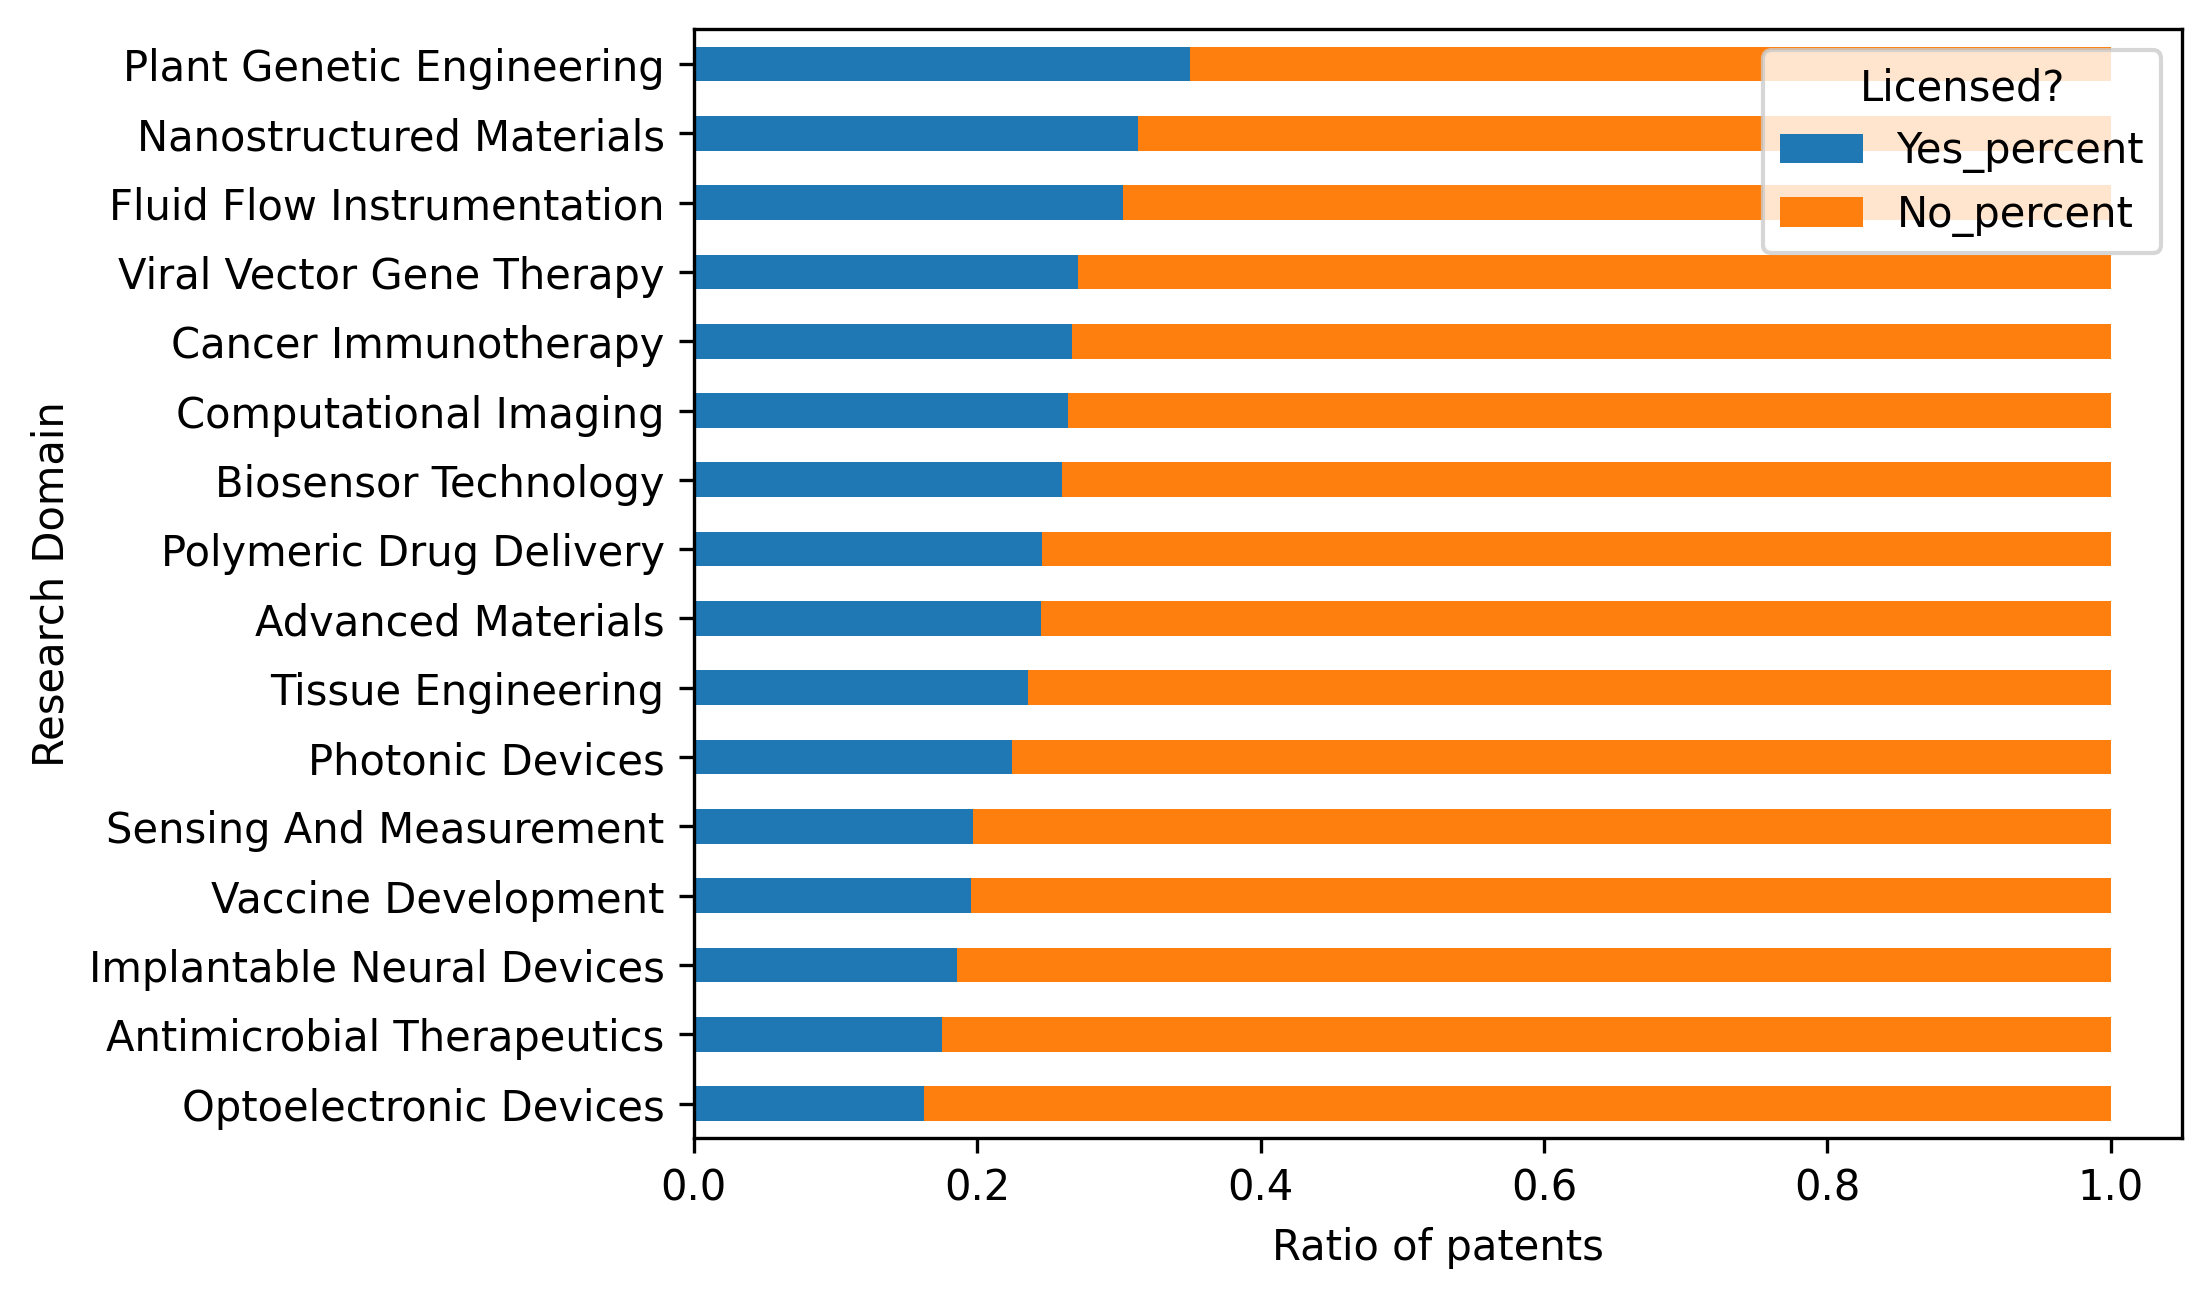

In [273]:
cluster_groups['Total'] = cluster_groups['Yes'] + cluster_groups['No']
cluster_groups['Yes_percent'] = cluster_groups['Yes']/cluster_groups['Total']
cluster_groups['No_percent'] = cluster_groups['No']/cluster_groups['Total']
cluster_groups = cluster_groups.sort_values('Yes_percent',ascending=True)
cluster_groups[['Yes_percent','No_percent']].plot(kind='barh',stacked=True)
print(cluster_groups.sort_values('Total',ascending=False))
plt.xlabel('Ratio of patents')
plt.ylabel('Research Domain')
plt.show()

## Conclusions

### Key Findings

- **Photonic Devices**, **Advanced Materials**, and **Viral Vector Gene Therapy** saw the highest number of patents applied for, at over **230 each**

- **Plant Genetic Engineering** sees the highest success rate with 35% of patents being licensed. **Optoelectronic Devices** are the least successful, with only 16% of patents licensed, although the similar field of **Photonics Devices** sees more success (22%)

- The majority of patents are funded by **EPSRC**, **BBSRC,** or **MRC**

### Limitations

- Cluster labels are LLM-generated from a sample of only 50 patents each

- Licensing status reflects commercialisation, not necessarily impact or quality

- Clustering performance could be improved, either by further preprocessing or trying different transformer models

- Somewhat low silhouette scores (0.35-0.40) suggest overlap of clusters, data may inherently be difficult to cluster
